# Table Of Content
<a id='data_analysis'></a>
#### [1.Dummy Model](#DummyModel)

# Business Understanding

We are the data science team for an investment consulting company. Our problem is that we want to make use of social media data to inform investing advice based on predicting sentiment of text that includes a given brand's name and/or products. Our first foray into this work is to build a model that predicts the sentimet of tweets on Twitter/ X, using the categories positive, negative or neutral. Our predictors include a brand-name (Apple or Google) and product name (Android, iPhone, etc). Our goal is to develop a high-accuracy model to gauge brand satisfaction. We'll use the sentiment of the tweet to compare the proportion of positive reviews associated with Apple products versus Google products. The creation of this model can then be generalized by training it on a wider range of data from social media in order to gauge brand satisfaction segmented by attributes such as event hashtags, top brand influencers or how sentiment for a given brand, product, or product model has evolved over time.

# Data Understanding

>- The subject of our Twitter/ X data centers on the 2013 SXSW conference [here](https://schedule.sxsw.com/2013/events/grid?day=8)
>- South by Southwest (SXSW) is a multi-conference event of interactive media, music and film that occurs in Austin, Texas each year in March. Each tweet in our data mentions either Apple products, Google products, or both as well as specific products under those brands.
We sourced our data from data.world which can be found [here](https://data.world/crowdflower/brands-and-product-emotions)

#### Number of Instances:
>- 9,093

#### Features:
>- Text string of entire tweet
>- emotion_in_tweet_is_directed_at
>- Product and/or Brand mentioned in tweet
>- is_there_an_emotion_directed_at_a_brand_or_product
#### This is our predictor value
>-Values for sentiment of tweet:
>>- Positive Emotion
>>- Negative Emotion
>>- No emotion toward brand or product
>>- I can't tell

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import defaultdict
import numpy as np
import pandas as pd
import unicodedata
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk.collocations as collocations
from nltk.util import ngrams
import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score,  confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, RocCurveDisplay, log_loss
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import datasets, layers, models, callbacks
from kerastuner.tuners import RandomSearch
from keras import backend as K
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

Using TensorFlow backend


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/danayt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/danayt/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/danayt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# !pip install wordcloud

In [3]:
import sklearn
sklearn.__version__

'1.3.1'

In [4]:
# !pip install keras-tuner

In [5]:
data = pd.read_csv("./raw_data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

In [6]:
# dopping null column from tweet_text column since it's only one and has no information for our analysis
data.tweet_text.isna().sum()
data.dropna(subset=['tweet_text'], inplace=True)

In [7]:
# looking at our .describe, there seems to be some duplicates in our data and we'll go ahead and keep unique inputs only
data.drop_duplicates(subset=['tweet_text'], inplace=True)

In [8]:
# Creating a cleaned emotion_in tweet_is_directed_at column
data.rename(columns={'emotion_in_tweet_is_directed_at': 'brand'}, inplace=True)
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [9]:
keywords = ["Apple", "Google", "iPad", "iPhone", "Android", "goog"]

for keyword in keywords:
    data[keyword] = data['tweet_text'].str.extract(f'({keyword})', flags=re.IGNORECASE)

data['product'] = data[['Apple', 'iPhone', 'iPad', 'Google', 'Android']].apply(lambda x: 'Apple' if x[['Apple', 'iPhone', 'iPad']].any() 
                                                                                else 'Google' if x[['Google', 'Android']].any() 
                                                                                else None, axis=1)

In [10]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

In [11]:
# Since we've classified our product column, we'll drop nulls as we're interested with apple and google products
data['product'].isna().sum()

784

In [12]:
#Dropped to focus on tweets where google and apple where mentioned
data.dropna(subset=['product'], inplace=True)

In [13]:
data['sentiment'].replace("I can't tell" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)

In [14]:
target_to_replace = {'Positive emotion':2, 'Neutral emotion':1,
                   'Negative emotion':0}

data['sentiment']  = data['sentiment'].replace(target_to_replace)

In [15]:
data['sentiment'].value_counts(normalize=True)

sentiment
1    0.577587
2    0.353822
0    0.068591
Name: proportion, dtype: float64

In [16]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

In [154]:
Apple_data = data[data['product']== 'Apple']

In [156]:
Apple_data['sentiment'].value_counts(normalize=True)

sentiment
1    0.538880
2    0.385173
0    0.075947
Name: proportion, dtype: float64

In [17]:
data['product'] = data['product'].astype(str)

In [18]:
sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "hmmm","rt" "sxswu", "goog", "iusxsw",
           "etc", "via", "today", "hmmmm"])

In [19]:
# Custom tokenizer
def doc_preparer(doc, stop_words=sw):

    #lemmatized, parsed for stopwords, made lowercase,and stripped of punctuation and numbers.
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove URLs
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    # Remove mentions and hashtags
    doc = re.sub(r'\@\w+|\#','', doc)
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = [word for word in doc if len(word) > 2]  # Remove tokens with length <= 1
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)
 # Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [20]:
# Extracting important features from our data 
corpse = data.tweet_text
target = data.sentiment
product = data.product

In [21]:
token_text = [doc_preparer(doc,sw) for doc in corpse]

In [22]:
# Convert the 'product' column to strings
data['product'] = data['product'].astype(str)

# Concatenate the "corpse" and "product" columns
data['text_with_product'] = [text + ' ' + product for text, product in zip(token_text, data['product'])]

In [23]:
data

,tweet_text,brand,sentiment,Apple,Google,iPad,iPhone,Android,goog,product,text_with_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,NaN,NaN,NaN,iPhone,NaN,NaN,Apple,hr tweet rise austin dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,2,NaN,NaN,iPad,iPhone,NaN,NaN,Apple,know awesome app likely appreciate design also...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,2,NaN,NaN,iPad,NaN,NaN,NaN,Apple,wait also sale Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,NaN,NaN,NaN,iPhone,NaN,NaN,Apple,hope year festival crashy year app Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,2,NaN,Google,NaN,NaN,NaN,Goog,Google,great stuff fri marissa mayer tim reilly tech ...
...,...,...,...,...,...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,2,NaN,NaN,Ipad,NaN,NaN,NaN,Apple,everywhere Apple
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,1,NaN,google,NaN,NaN,NaN,goog,Google,wave buzz interrupt regularly schedule geek pr...
9090,"Google's Zeiger, a physician never reported po...",NaN,1,NaN,Google,NaN,NaN,NaN,Goog,Google,zeiger physician never report potential yet fd...
9091,Some Verizon iPhone customers complained their...,NaN,1,NaN,NaN,NaN,iPhone,NaN,NaN,Apple,verizon customer complain time fell back hour ...


In [24]:
data.groupby(['product', 'sentiment']).count()

tweet_text  brand  Apple  Google  iPad  iPhone  Android  \
product sentiment                                                            
Apple   0                 419    389    116       1   189     161        8   
        1                2973     72   1168      27  1489     862      144   
        2                2125   1939    847      18  1198     546       54   
Google  0                 149    129      0     134     0       0       16   
        1                1810     28      0    1614     0       0      210   
        2                 805    698      0     668     0       0      142   

                   goog  text_with_product  
product sentiment                           
Apple   0             1                419  
        1            28               2973  
        2            19               2125  
Google  0           134                149  
        1          1614               1810  
        2           668                805

In [25]:
apple_sentiment = data['product'].groupby(data['sentiment'])

# Exploratory Data Analysis 

In [26]:
# Tokenize text by words for each row in the 'processed_text' column
data['tokenized_text'] = data['text_with_product'].apply(lambda x: word_tokenize(x))

In [27]:
# Check the number of words by summing the lengths of the tokenized lists
total_words = data['tokenized_text'].apply(len).sum()
total_words

74661

In [28]:
# Combine all the tokenized words into a single list
all_words = [word for tokenized_text in data['tokenized_text'] for word in tokenized_text]

# Calculate the frequency distribution
freq_dist = FreqDist(all_words)

# Print the top ten words
print(freq_dist.most_common(20))

[('Apple', 5517), ('Google', 2764), ('quot', 1583), ('store', 1507), ('new', 1047), ('austin', 901), ('app', 774), ('launch', 762), ('amp', 731), ('circle', 664), ('get', 656), ('social', 627), ('pop', 607), ('open', 503), ('network', 458), ('line', 456), ('call', 383), ('party', 353), ('mobile', 341), ('come', 317)]


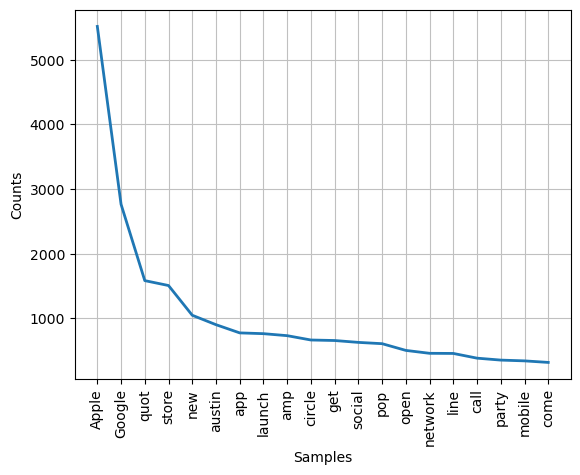

In [29]:

#Plot the 10 most common words
freq_dist.plot(20)
plt.show();

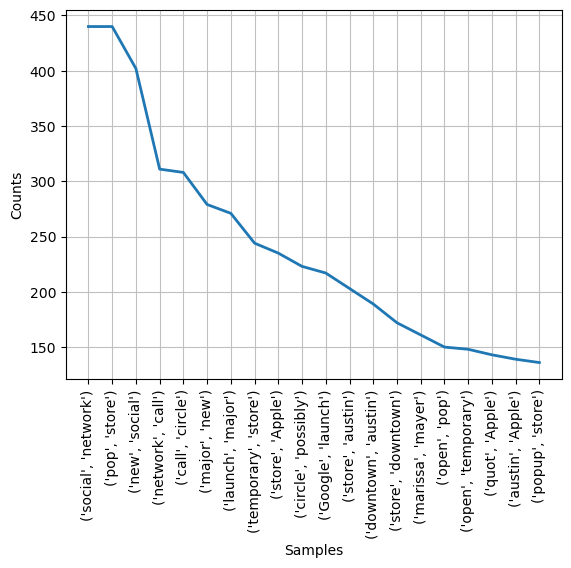

<Axes: xlabel='Samples', ylabel='Counts'>

In [30]:
bigrams = nltk.bigrams(all_words)
tokenized_bigrams = nltk.FreqDist(bigrams)
tokenized_bigrams.most_common(20)
tokenized_bigrams.plot(20)

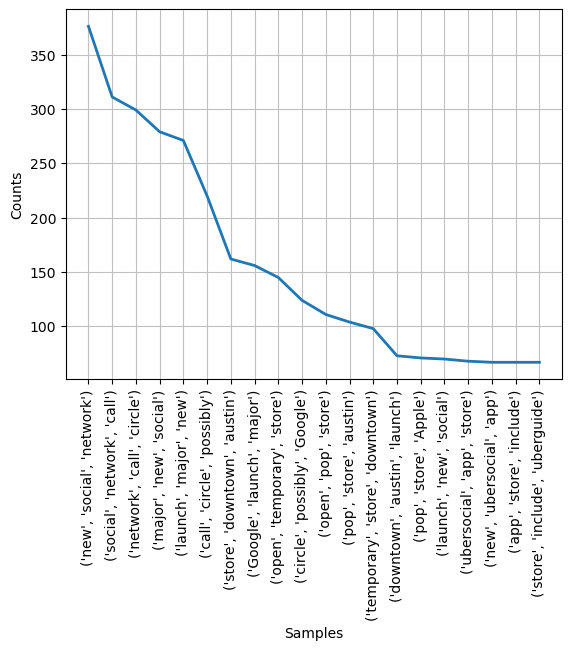

<Axes: xlabel='Samples', ylabel='Counts'>

In [31]:
bigrams = nltk.trigrams(all_words)
tokenized_bigrams = nltk.FreqDist(bigrams)
tokenized_bigrams.most_common(20)
tokenized_bigrams.plot(20)

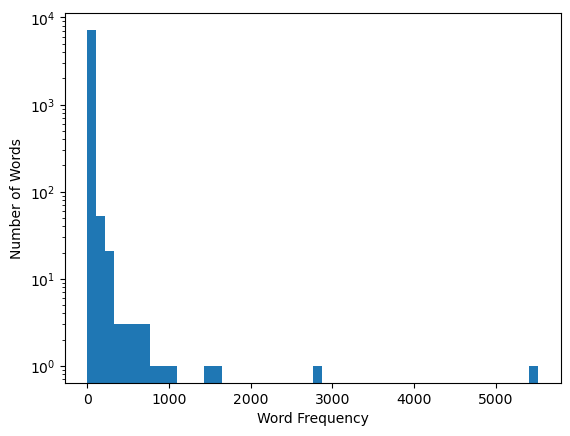

In [32]:
# Vectorize the text
vectorizer = CountVectorizer()
corpse = ()
X = vectorizer.fit_transform(data['text_with_product'])

# Sum the word frequencies
word_freq = X.sum(axis=0)

# Convert to a numpy array and flatten
word_freq = word_freq.A1

# Plot the distribution
plt.hist(word_freq, bins=50, log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.show();

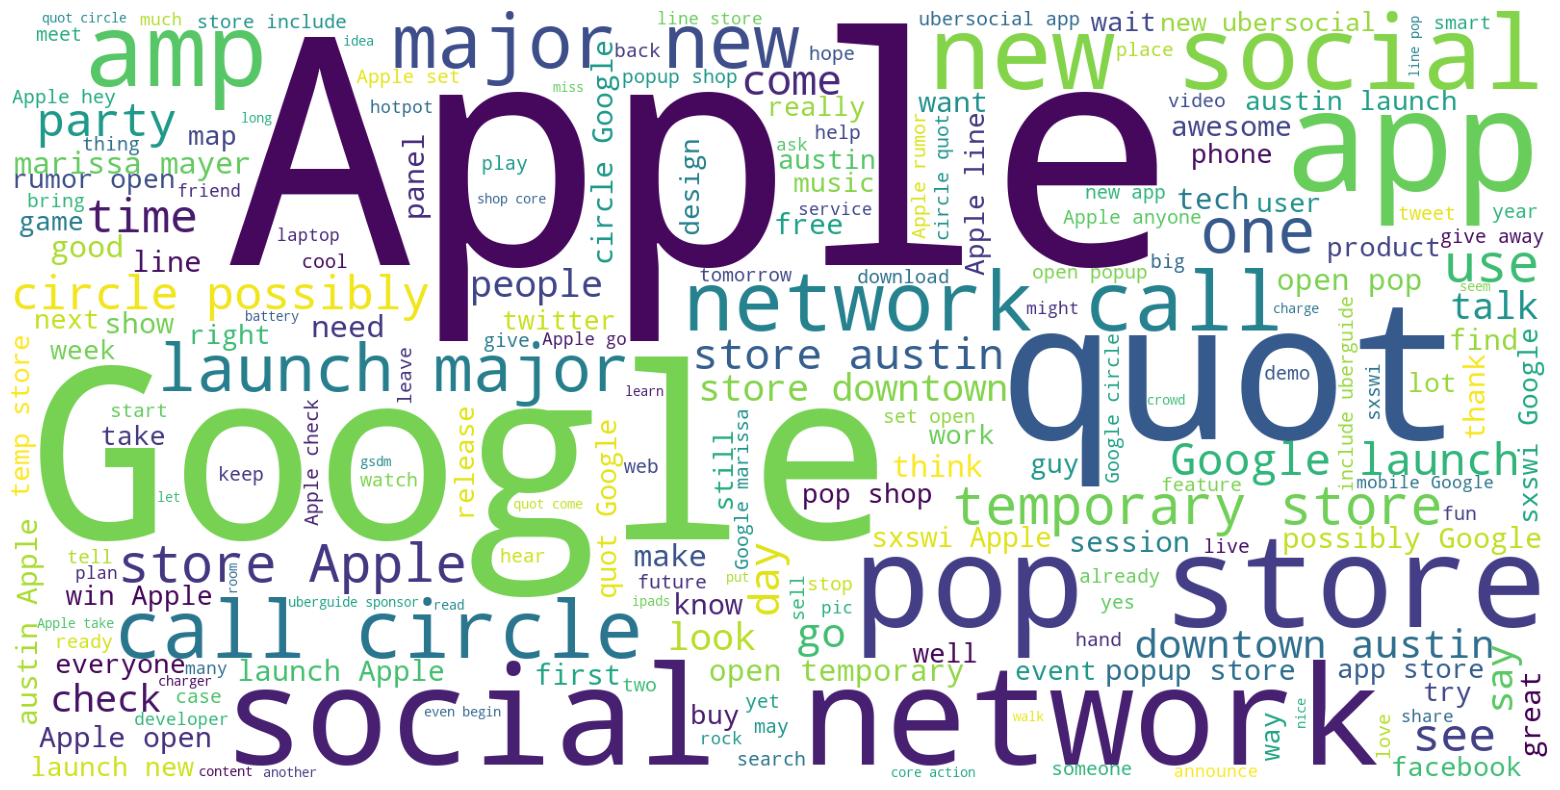

<Figure size 640x480 with 0 Axes>

In [33]:
#Convert word list to a single string
words_string = " ".join(all_words)

#generating the wordcloud
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(words_string)

#plot the wordcloud
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show();

plt.savefig("cloudword.png")

# Train test split and evaluation metrics

In [34]:
# Assign the concatenated text to X
X = data['text_with_product']

# Assign the target labels to y
y = data['sentiment']

In [35]:
X_train_in, X_test, y_train_in, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train_in,
                                                    y_train_in,
                                                    random_state=42,
                                                    test_size=0.2)

In [37]:
class EvaluationMetrics:
    model_df =[]
    model_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Train Recall', 'Train Precision', 'Train F1-Score',
                                              'Train Log Loss','Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1-Score',
                                              'Test Log Loss', 'Validation Accuracy', 'Validation Recall', 'Validation Precision', 
                                              'Validation F1-Score'])
                           
    def __init__(self, pipe, X_train, X_test, y_train, y_test, X_val, y_val):
        self.pipe = pipe
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val

    def print_scores(self):
        # Training set predictions
        y_train_pred = self.pipe.predict(self.X_train)
        y_train_pred_proba = self.pipe.predict_proba(self.X_train)
        train_results_dict = {'accuracy': accuracy_score(self.y_train, y_train_pred),
                              'recall': recall_score(self.y_train, y_train_pred, average='weighted'),
                              'precision': precision_score(self.y_train, y_train_pred, average='weighted'),
                              'f1_score': f1_score(self.y_train, y_train_pred, average='weighted'),
                              'log_loss': log_loss(self.y_train, y_train_pred_proba)}

        # Test set predictions
        y_test_pred = self.pipe.predict(self.X_test)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        test_results_dict = {'accuracy': accuracy_score(self.y_test, y_test_pred),
                             'recall': recall_score(self.y_test, y_test_pred, average='weighted'),
                             'precision': precision_score(self.y_test, y_test_pred, average='weighted'),
                             'f1_score': f1_score(self.y_test, y_test_pred, average='weighted'),
                             'log_loss': log_loss(self.y_test, y_test_pred_proba)}

        # Validation set predictions
        y_val_pred = self.pipe.predict(self.X_val)
        y_val_pred_proba = self.pipe.predict_proba(self.X_val)
        val_results_dict = {'accuracy': accuracy_score(self.y_val, y_val_pred),
                            'recall': recall_score(self.y_val, y_val_pred, average='weighted'),
                            'precision': precision_score(self.y_val, y_val_pred, average='weighted'),
                            'f1_score': f1_score(self.y_val, y_val_pred, average='weighted'),
                            'log_loss': log_loss(self.y_val, y_val_pred_proba)}

        return train_results_dict, test_results_dict, val_results_dict
        
    def cross_validation(self, cv=5):
        scores = cross_val_score(self.pipe, self.X_train, self.y_train, cv=cv, scoring='accuracy')
        return np.mean(scores), np.std(scores)
        
    # Plots ROC curve for all classes 
    def plot_roc_curve_ovr(self):
        # Calculate FPR and TPR for each class (One-vs-Rest)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        n_classes = y_test_pred_proba.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test, y_test_pred_proba[:, i], pos_label=i)

        # Plot ROC curve for each class (One-vs-Rest)
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - One-vs-Rest')
        plt.legend(loc="lower right")
        plt.show()
        
    # Plots confusion matrix
    def plot_confusion_matrix(self, y_train, y_train_pred):
        cm = confusion_matrix(y_train, y_train_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        
    def record_results(self, model_name, train_results, test_results, val_results):
        new_row = {'Model': model_name,
               'Train Accuracy': train_results['accuracy'],
               'Train Recall': train_results['recall'],
               'Train Precision': train_results['precision'],
               'Train F1-Score': train_results['f1_score'],
               'Train Log Loss': train_results['log_loss'],
               'Test Accuracy': test_results['accuracy'],
               'Test Recall': test_results['recall'],
               'Test Precision': test_results['precision'],
               'Test F1-Score': test_results['f1_score'],
               'Test Log Loss': test_results['log_loss'],
               'Validation Accuracy': val_results['accuracy'],
               'Validation Recall': val_results['recall'],
               'Validation Precision': val_results['precision'],
               'Validation F1-Score': val_results['f1_score'],
               'Validation Log Loss': val_results['log_loss']}
        new_row_df= pd.DataFrame(new_row, index=[0])
        self.model_df = pd.concat([self.model_df, new_row_df],ignore_index=True)
        
        # self.model_df.loc[len(self.model_df)] = new_row
        # results = pd.concat([self.model_df, results, results_1], ignore_index =True)

# DummyModel

In [38]:
dummy = Pipeline([
    ('vect', CountVectorizer(min_df=0.05, max_df=0.95)),
    ('dummy', DummyClassifier(random_state=42, ))
])

# Fit the pipeline to the training data
dummy.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('dummy', DummyClassifier(random_state=42))])

In [39]:
dummy_metrics = EvaluationMetrics(dummy, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = dummy_metrics.print_scores()
dummy_metrics.record_results('DummyModel', train_results, test_results, val_results)

In [40]:
dummy_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.576901,0.576901,0.332815,0.422113,0.872006,0.586602,0.586602,0.344102,0.43376,0.847863,0.569057,0.569057,0.323825,0.412764,0.880097


# Logistic regression
#### Logistic Regression using CountVectorizer

In [41]:
lg_cv = Pipeline([
    ('vect', CountVectorizer(min_df=0.05, max_df=0.75,)),
    ('logreg', LogisticRegression(random_state=42, ))
])

# Fit the pipeline to the training data
lg_cv.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.75, min_df=0.05)),
                ('logreg', LogisticRegression(random_state=42))])

In [42]:
lg_cv_metrics = EvaluationMetrics(lg_cv, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_cv_metrics.print_scores()
lg_cv_metrics.record_results('Logreg_countV', train_results, test_results, val_results)

In [43]:
lg_cv_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_countV,0.582751,0.582751,0.514339,0.491101,0.84424,0.596862,0.596862,0.541779,0.510877,0.829435,0.571321,0.571321,0.503846,0.479886,0.859683


#### Logistic regression with Tf-idf vectorizer
>- Model preformed better than out baseline as well as countvector vectorizer on training set
>- But not so well on test and validation, this could be a product of overfitting and the initial class imbalance observed
>- Logistic regression models are prone to overfit when models too complex, or with insuficient regulirization
>- We'll apply smote, some hyperparameters to see if that'll improve performance

In [149]:
lg_tfidf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 1))),
    ('logreg', LogisticRegression(random_state=42))
])

# Fit the pipeline to the training data
lg_tfidf.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('logreg', LogisticRegression(random_state=42))])

In [150]:
lg_tfidf_metrics = EvaluationMetrics(lg_tfidf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_tfidf_metrics.print_scores()
lg_tfidf_metrics.record_results('Logreg_TF-IDF', train_results, test_results, val_results)

In [151]:
lg_tfidf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_TF-IDF,0.799207,0.799207,0.816957,0.779669,0.532878,0.662643,0.662643,0.655401,0.63475,0.72909,0.645283,0.645283,0.645948,0.615897,0.759868


#### Smote Logistic Regression with TF_IDF
>- Using SMOTE and balanced class weight among limiting vector features adresses our overfitting
>- Model training, validation and test result in similar accuracy rates
>- logloss is high and performance has decreased from previous overfit lr model

In [47]:
from imblearn.over_sampling import SMOTE
# Create an instance of SMOTE
smote = SMOTE()

# Define the pipeline
lg_sm = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 1),min_df=0.01, max_df=0.75,max_features=1000),
    smote,
    LogisticRegression(random_state=42,multi_class='multinomial', C=0.01, penalty='l2', class_weight='balanced', max_iter=125)
)

# Fit the pipeline to the training data
lg_sm.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01)),
                ('smote', SMOTE()),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=125, multi_class='multinomial',
                                    random_state=42))])

In [48]:
lg_sm_metrics = EvaluationMetrics(lg_sm, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_sm_metrics.print_scores()
lg_sm_metrics.record_results('Logreg_TF-IDF_Smote', train_results, test_results, val_results)

In [49]:
lg_sm_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_TF-IDF_Smote,0.498396,0.498396,0.612861,0.529896,1.037509,0.464092,0.464092,0.595276,0.504024,1.049792,0.455849,0.455849,0.57082,0.488875,1.05413


## PCA
### TruncatedSVD
#### Our data could be having a lot of noise and one method to deal with it is using dimension reduction
>- Using TruncatedSVD our result was still not that better, the parameters applied are best gridsearched prams
>- Model's performance is balanced but accuracy is low

In [142]:
lg_sm_pca = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000),
    LatentDirichletAllocation(n_components=100),  # Specify the desired number of components
    smote,
    LogisticRegression(random_state=42, multi_class='multinomial', C=0.01, penalty='l2', class_weight='balanced', solver='saga')
)
lg_sm_pca.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('latentdirichletallocation',
                 LatentDirichletAllocation(n_components=100)),
                ('smote', SMOTE()),
                ('logisticregression',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    multi_class='multinomial', random_state=42,
                                    solver='saga'))])

In [143]:
lg_sm_pca_metrics = EvaluationMetrics(lg_sm_pca, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_sm_pca_metrics.print_scores()
lg_sm_pca_metrics.record_results('Logreg_TF-IDF_TSVD', train_results, test_results, val_results)

In [145]:
lg_sm_pca_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_TF-IDF_TSVD,0.449896,0.449896,0.594369,0.479348,1.078773,0.417019,0.417019,0.56272,0.453439,1.083699,0.427925,0.427925,0.561931,0.45529,1.082074


### Negative Matrix Factorization
>- NMF has better model performance on accuracy from other pca methods 

In [53]:
lg_nmf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000)),
    ('nmf', NMF(n_components=125)),  # Specify the desired number of component 
    ('logreg', LogisticRegression(random_state=42, multi_class='multinomial', penalty='l2'))
])
lg_nmf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('nmf', NMF(n_components=125)),
                ('logreg',
                 LogisticRegression(multi_class='multinomial',
                                    random_state=42))])

In [54]:
lg_nmf_metrics = EvaluationMetrics(lg_nmf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lg_nmf_metrics.print_scores()
lg_nmf_metrics.record_results('Logreg_TF-IDF_NMF', train_results, test_results, val_results)

In [55]:
lg_nmf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logreg_TF-IDF_NMF,0.601057,0.601057,0.571885,0.49748,0.832209,0.602897,0.602897,0.573399,0.496514,0.821266,0.582642,0.582642,0.536486,0.481399,0.850956


In [56]:
# Smote with NMF

# MultinomialNB Model 
>- Model performed better than our logistic regression trials above but it is performing much better on training set than test set
>- We are using best params from previously grid searched prams

In [57]:
mnbpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features= 500)),
    ('mnb', MultinomialNB(alpha=2.0, fit_prior=True))
])

# Fit the pipeline to the training data
mnbpipe.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.75, max_features=500, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('mnb', MultinomialNB(alpha=2.0))])

In [58]:
mnbpipe_metrics = EvaluationMetrics(mnbpipe, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = mnbpipe_metrics.print_scores()
mnbpipe_metrics.record_results('MultinomialNB_TF-IDF_', train_results, test_results, val_results)

In [59]:
mnbpipe_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,MultinomialNB_TF-IDF_,0.637101,0.637101,0.590073,0.585797,0.793685,0.636693,0.636693,0.597718,0.582559,0.801621,0.606792,0.606792,0.552482,0.550173,0.829588


### Negative Matrix Factorization
>- Using dimesion reduction for better model performance

In [60]:
mnb_nmf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.95, max_features=100)),
    ('nmf', NMF(n_components=100)),  # Specify the desired number of component 
    ('mnb', MultinomialNB(alpha=2.0, fit_prior=True))
])
mnb_nmf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=100, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('nmf', NMF(n_components=100)),
                ('mnb', MultinomialNB(alpha=2.0))])

In [61]:
mnb_nmf_metrics = EvaluationMetrics(mnb_nmf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = mnb_nmf_metrics.print_scores()
mnb_nmf_metrics.record_results('MultinomialNB_TF-IDF_NMF', train_results, test_results, val_results)

In [62]:
mnb_nmf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,MultinomialNB_TF-IDF_NMF,0.578411,0.578411,0.650603,0.425859,0.854631,0.59143,0.59143,0.70063,0.44461,0.835144,0.569057,0.569057,0.502753,0.414117,0.863524


# Random Forest Model
>- with gridsearched best hyperperameters

In [63]:
rfpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, analyzer='word', max_features=1000)),
    ('rf', RandomForestClassifier(n_estimators=300,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False ))
])

# Fit the pipeline to the training data
rfpipe.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=20, n_estimators=300))])

In [64]:
rfpipe_metrics = EvaluationMetrics(rfpipe, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = rfpipe_metrics.print_scores()
rfpipe_metrics.record_results('RandomForest_TF-IDF', train_results, test_results, val_results)

In [65]:
rfpipe_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,RandomForest_TF-IDF,0.75033,0.75033,0.810775,0.721688,0.60395,0.634882,0.634882,0.631516,0.576357,0.784803,0.617358,0.617358,0.595659,0.557862,0.820927


### Negative Matrix Factorization

In [66]:
rf_nmf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.95, max_features=100)),
    ('nmf', NMF(n_components=70)),  # Specify the desired number of component 
    ('rf', RandomForestClassifier(n_estimators=300,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False ))
])
rf_nmf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=100, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('nmf', NMF(n_components=70)),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=20, n_estimators=300))])

In [67]:
rf_nmf_metrics = EvaluationMetrics(rf_nmf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = rf_nmf_metrics.print_scores()
rf_nmf_metrics.record_results('RandomForest_TF-IDF_NMF', train_results, test_results, val_results)

In [68]:
rf_nmf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,RandomForest_TF-IDF_NMF,0.781091,0.781091,0.817948,0.762515,0.53743,0.635486,0.635486,0.613537,0.588339,0.806922,0.603774,0.603774,0.572659,0.553314,0.846019


#### TruncatedSVD

In [69]:
rf_svd = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000),
    TruncatedSVD(n_components=125),  # Specify the desired number of components
    smote,
    RandomForestClassifier(n_estimators=200,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False)
)
rf_svd.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.75, max_features=1000, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('truncatedsvd', TruncatedSVD(n_components=125)),
                ('smote', SMOTE()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=20, n_estimators=200))])

In [70]:
rf_svd_metrics = EvaluationMetrics(rf_svd, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = rf_svd_metrics.print_scores()
rf_svd_metrics.record_results('RandomForest_TF-IDF_SVD', train_results, test_results, val_results)

In [71]:
rf_svd_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,RandomForest_TF-IDF_SVD,0.86639,0.86639,0.878169,0.869655,0.277169,0.575136,0.575136,0.587601,0.58079,0.97691,0.567547,0.567547,0.577553,0.571962,1.219606


# XGBoosting
>- With smote, TF-IDF and NMF dimension reduction
>- XGBoosting perfomed better with countvectorizer than TF-IDF

In [72]:
# Create an instance of TfidfVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))
sm = SMOTE()

# Define the individual classifiers
lg = LogisticRegression(random_state=42,multi_class='multinomial', C=0.01, penalty='l2', class_weight='balanced', max_iter=1000)
mnb = MultinomialNB(alpha=2.0, fit_prior=True)
nmf = NMF(n_components=100)

rf = RandomForestClassifier(n_estimators=200,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False)
xgb = XGBClassifier(
    estimators=[
        ('lg', lg),
        ('mnb', mnb),
        ('rf', rf)
    ],
    voting='soft',max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    verbosity=1,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=42,
)

xgb_pipeline = make_pipeline(vectorizer,sm, nmf,xgb)

# xgb_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()), ('nmf', NMF(n_components=100)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               estimators=[('lg',
                                            LogisticRegre...
                               eval_metric=None, feature_types=None, gamma=0,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=0,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100, n_jobs=1,
                               nthread=None, ...))])

In [73]:
xgb_pipeline_metrics = EvaluationMetrics(xgb_pipeline, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = xgb_pipeline_metrics.print_scores()
xgb_pipeline_metrics.record_results('XGBoosting_CountV_SVD', train_results, test_results, val_results)

In [74]:
xgb_pipeline_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,XGBoosting_CountV_SVD,0.670126,0.670126,0.660349,0.660417,0.770574,0.606518,0.606518,0.585449,0.589614,0.838885,0.597736,0.597736,0.579042,0.583814,0.870415


In [75]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
sm = SMOTE()

# Define the individual classifiers
lg = LogisticRegression(random_state=42,multi_class='multinomial', C=0.01, penalty='l2', class_weight='balanced', max_iter=1000)
mnb = MultinomialNB(alpha=2.0, fit_prior=True)
nmf = NMF(n_components=100)

rf = RandomForestClassifier(n_estimators=200,criterion = 'entropy', max_features='sqrt',max_depth=20,bootstrap=False)
xgb_tfidf = XGBClassifier(
    estimators=[
        ('lg', lg),
        ('mnb', mnb),
        ('rf', rf)
    ],
    voting='soft',max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    verbosity=1,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=42,
)

xgb_pipe_tfidf = make_pipeline(vectorizer,sm, nmf,xgb_tfidf)

# xgb_pipeline.fit(X_train, y_train)
xgb_pipe_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()), ('nmf', NMF(n_components=100)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               estimators=[('lg',
                                            LogisticRegre...
                               eval_metric=None, feature_types=None, gamma=0,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=0,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100, n_jobs=1,
                               nthread=None, ...))])

In [76]:
xgb_tfidf_metrics = EvaluationMetrics(xgb_pipe_tfidf, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = xgb_tfidf_metrics.print_scores()
xgb_tfidf_metrics.record_results('XGBoosting_TF-IDF_SVD', train_results, test_results, val_results)

In [77]:
xgb_tfidf_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,XGBoosting_TF-IDF_SVD,0.661257,0.661257,0.697591,0.670524,0.785086,0.56548,0.56548,0.585288,0.574007,0.883996,0.563019,0.563019,0.578567,0.569391,0.888227


# Embedding

In [78]:
#How to pull a specific predictor out

In [ ]:
K.clear_session
# Preprocess your text data and split into train and test sets
X_train_em, X_test_em, y_train_em, y_test_em = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.utils import class_weight

# Vectorize the text data using TF-IDF
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000)
X_train_vectorized = vectorizer.fit_transform(X_train_em)
X_test_vectorized = vectorizer.transform(X_test_em)

# Apply LDA for dimensionality reduction
lda = LatentDirichletAllocation(n_components=100)
X_train_lda = lda.fit_transform(X_train_vectorized)
X_test_lda = lda.transform(X_test_vectorized)

# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=X_train_lda.shape[1], output_dim=100, input_length=X_train_lda.shape[1]))
model.add(LSTM(128))
model.add(Dense(12, activation='sigmoid'))


class_weight = class_weight.compute_sample_weight('balanced',y_train_em)
# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train_lda, y_train_em, validation_data=(X_test_lda, y_test),epochs=5, batch_size=32)

In [ ]:
# With Logistic Regression

In [135]:
from sklearn.multiclass import OneVsRestClassifier

# Vectorize the text data using TF-IDF
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000)
X_train_vectorized = vectorizer.fit_transform(X_train_em)
X_test_vectorized = vectorizer.transform(X_test_em)

# dimensionality reduction
lda = LatentDirichletAllocation(n_components=100)
X_train_lda = lda.fit_transform(X_train_vectorized)
X_test_lda = lda.transform(X_test_vectorized)

# Assuming you have your target labels stored in a variable called "y"
# Train a logistic regression model using the topic distributions as features
logreg = LogisticRegression()
model = OneVsRestClassifier(logreg)
model.fit(X_train_lda, y_train_em)

OneVsRestClassifier(estimator=LogisticRegression())

In [139]:
y_pred = model.predict(X_test_lda)

In [141]:
print(classification_report(y_test_em, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.61      0.88      0.72       972
           2       0.53      0.23      0.33       588

    accuracy                           0.60      1657
   macro avg       0.38      0.37      0.35      1657
weighted avg       0.55      0.60      0.54      1657



# Apple

In [158]:
apple_corpse = Apple_data['tweet_text']

In [159]:
token_apple = [doc_preparer(doc,sw) for doc in apple_corpse]

In [162]:
X_a = Apple_data['text_with_product']


y_a = Apple_data['sentiment']

In [163]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a,
                                                    y_a,
                                                    random_state=42,
                                                    test_size=0.2)

In [164]:
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, max_features=1000)
X_train_vectorized = vectorizer.fit_transform(X_train_a)
X_test_vectorized = vectorizer.transform(X_test_a)

# dimensionality reduction
lda = LatentDirichletAllocation(n_components=100)
X_train_lda = lda.fit_transform(X_train_vectorized)
X_test_lda = lda.transform(X_test_vectorized)

# Train a logistic regression model using the topic distributions as features
logreg = LogisticRegression()
model = OneVsRestClassifier(logreg)
model.fit(X_train_lda, y_train_a)

OneVsRestClassifier(estimator=LogisticRegression())

In [166]:
y_pred = model.predict(X_test_lda)
print(classification_report(y_test_a, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.55      0.88      0.68       571
           2       0.57      0.24      0.33       450

    accuracy                           0.55      1104
   macro avg       0.37      0.37      0.34      1104
weighted avg       0.52      0.55      0.49      1104

